# First
batch size 2-48 lr 1e-4

### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
os.environ['MKL_THREADING_LAYER']='GNU'
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/giles/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


## Options

In [8]:
classTrainFeatures = basic_features
classModel = 'modelSelu'
varSet = "basic_features"

nSplits = 10
ensembleSize = 10
ensembleMode = 'loss'

maxEpochs = 200
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 2048, 'verbose' : 0}
modelParams = {'version':classModel, 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs}

print "\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures]


Training on 5 features: ['jetPt', 'jetEta', 'jetMass', 'ntracks', 'ntowers']


## Import data

In [9]:
trainData = h5py.File(dirLoc + 'train.hdf5', "r+")
valData = h5py.File(dirLoc + 'testing.hdf5', "r+")

## Determine LR

2 classes found, running in binary mode


______________________________________
Training finished
Cross-validation took 2.112s 


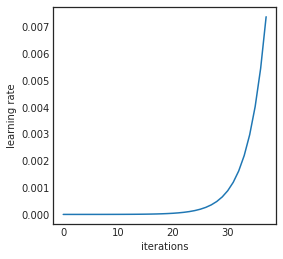

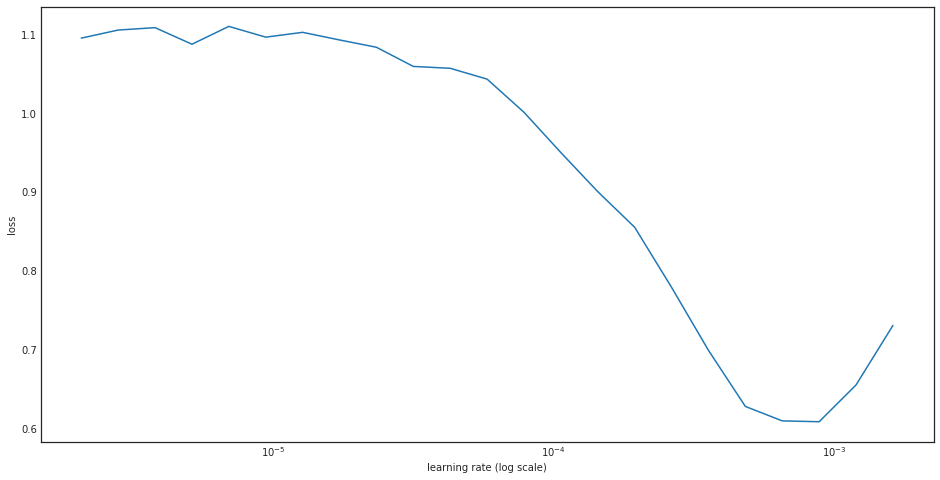

______________________________________



In [10]:
lrFinder = batchLRFindClassifier(trainData, nSplits, getClassifier, modelParams, trainParams, lrBounds=[1e-7,1e-2], trainOnWeights=False, verbose=0)

In [11]:
compileArgs['lr'] = 1e-4

## Train classifier

In [ ]:
results, histories = batchTrainClassifier(trainData, nSplits, getClassifier, modelParams, trainParams, patience=100, cosAnnealMult=1, trainOnWeights=False, maxEpochs=maxEpochs, verbose=1)

Using cosine annealing
Running fold 1 / 10
2 classes found, running in binary mode

1 New best found: 0.543487763718
2 New best found: 0.51185213769
3 New best found: 0.497975116831
4 New best found: 0.493055578728
5 New best found: 0.491288278488
6 New best found: 0.490700750206
7 New best found: 0.490303892751
8 New best found: 0.490019188647
9 New best found: 0.489786070178
11 New best found: 0.489479152631
12 New best found: 0.489365952382
13 New best found: 0.489340575199
15 New best found: 0.489164440108
16 New best found: 0.489034940767
17 New best found: 0.488979081508
19 New best found: 0.488907759238
21 New best found: 0.488848380909
22 New best found: 0.488787553838
23 New best found: 0.48873623316


## Construct ensemble

In [ ]:
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [ ]:
ensemble, weights = assembleEnsemble(results, ensembleSize, ensembleMode, compileArgs)

## Response on development data

In [ ]:
batchEnsemblePredict(ensemble, weights, trainData, ensembleSize=10, verbose=1)

In [ ]:
print 'Training ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', trainData), getFeature('pred', trainData)),
                                                            roc_auc_score(getFeature('targets', trainData), getFeature('pred', trainData), sample_weight=getFeature('weights', trainData)))

## Response on val data

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=1)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData), getFeature('pred', valData)),
                                                           roc_auc_score(getFeature('targets', valData), getFeature('pred', valData), sample_weight=getFeature('weights', valData)))

## Evaluation

### Import in dataframe

In [ ]:
def convertToDF(datafile, columns={'gen_target', 'gen_weight', 'pred_class'}, nLoad=-1):
    data = pandas.DataFrame()
    data['gen_target'] = getFeature('targets', datafile, nLoad)
    data['gen_weight'] = getFeature('weights', datafile, nLoad)
    data['pred_class'] = getFeature('pred', datafile, nLoad)
    print len(data), "candidates loaded"
    return data

In [ ]:
valData = convertToDF(valData)

In [ ]:
sigVal = (valData.gen_target == 1)
bkgVal = (valData.gen_target == 0)

### MVA distributions

In [ ]:
getClassPredPlot([valData[bkgVal], valData[sigVal]], weightName='gen_weight')

In [ ]:
amsScan(valData)

In [ ]:
def scoreTest(ensemble, weights):
    testData = h5py.File(dirLoc + 'testing.hdf5', "r+")
    batchEnsemblePredict(ensemble, weights, testData, ensembleSize=10, verbose=1)

def saveTest(cut, name):
    testData = h5py.File(dirLoc + 'testing.hdf5', "r+")
    
    data = pandas.DataFrame()
    data['EventId'] = getFeature('EventId', testData)
    data['pred_class'] = getFeature('pred', testData)
    
    data['Class'] = 'b'
    data.loc[data.pred_class >= cut, 'Class'] = 's'

    data.sort_values(by=['pred_class'], inplace=True)
    data['RankOrder']=range(1, len(data)+1)
    data.sort_values(by=['EventId'], inplace=True)

    print dirLoc + name + '_test.csv'
    data.to_csv(dirLoc + name + '_test.csv', columns=['EventId', 'RankOrder', 'Class'], index=False)

In [ ]:
scoreTest(ensemble, weights)

In [ ]:
saveTest(0.93784874677658081, 'Day_2_Basic_Features_256_1e-3_swish_mult2_200E_normedweighted_rot_cart')

!kaggle competitions submit -c higgs-boson -f ../Data/Day_2_Basic_Features_256_1e-3_swish_mult2_200E_normedweighted_rot_cart_test.csv -m"Day2"